In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import seaborn as sns
from utils import *

In [2]:
'''
params options

na_data will fill missing data with 'unknown', delete missing data or do nothing
input options are...
    * 'fill'
    * 'drop'
    * False

drop_outlier_days removes pets who have a lenght of stay exceeding the value YOU enter
input options are...
    * False
    * or any integer

embed creates 50x1 embedding vectors for color and Intake_Subtype
    download https://nlp.stanford.edu/data/glove.6B.zip, unzip and save in repo
    * True
    * False

sample_dict controls stratified sampling
    * stratify_col: a column name used for stratified sampling... spelling and caps must be exact
    * train_size: a fraction of data you want for the training data
    * validate_size: a fraction of data you want for the validate data
    * test_size: a fraction of data you want for the test data

buckets what buckets will we split the data to?
    creates new column Days_in_Shelter_Label
    * input is a list of integers
    * please use [-1,3,14,30,100,99999999] as agreed upon based on shelter feedback

    '''

params = {
        'na_data': 'fill',
        'drop_outlier_days': 300,
        'embed':True,
        'buckets':[-1,3,14,30,100,99999999],
        'sample_dict':
            {
            'stratify_col':'Type',
            'train_size':0.6, 'validate_size':0.2, 'test_size':0.2
            }
        }
train_df, validate_df, test_df = load_df(params)
df = pd.concat([train_df, validate_df, test_df], ignore_index=True) # do this if you want to look at all the data still

Date Of Birth is NOT A STRING
Intake Date is NOT A STRING
Outcome Date is NOT A STRING
Days in Shelter is NOT A STRING
Count is NOT A STRING
replace null values in Name with 'Unknown'
replace null values in Size with 'Unknown'
replace null values in Outcome_Type with 'Unknown'
replace null values in Outcome_Subtype with 'Unknown'
replace null values in Outcome_Condition with 'Unknown'
replace null values in Outcome_Jurisdiction with 'Unknown'
replace null values in Outcome_Zip_Code with 'Unknown'
replace null values in Location with 'Unknown'
Intake Date is NOT A STRING
Outcome Date is NOT A STRING


/Users/robchimel/Documents/School/MIDS/210_Capstone/MIDS210-FURever-Home-Forecast/load_Denver.py:78: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Outcome Date'] = pd.to_datetime(df['Outcome Date'], errors='coerce')


replace null values in Name with 'Unknown'
replace null values in Date_Of_Birth with 'Unknown'
replace null values in Outcome_Type with 'Unknown'
replace null values in Intake_Subtype with 'Unknown'
replace null values in Outcome_Subtype with 'Unknown'
replace null values in Outcome_Condition with 'Unknown'
replace null values in Impound_Number with 'Unknown'
replace null values in Kennel_Number with 'Unknown'
replace null values in Animal_ID with 'Unknown'
replace null values in Intake_Jurisdiction with 'Unknown'
replace null values in Outcome_Jurisdiction with 'Unknown'
replace null values in Outcome_Zip_Code with 'Unknown'
replace null values in Location with 'Unknown'
replace null values in Multiple_Visit_Count with 'np.nan'
replace null values in Age_inDays_at_Income with 'np.nan'
replace null values in Age_Group with 'Unknown'
replace null values in Is_Mixed_Breed with 'np.nan'
replace null values in Is_Multicolor with 'np.nan'


/Users/robchimel/opt/anaconda3/envs/cv_281_3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/robchimel/opt/anaconda3/envs/cv_281_3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/robchimel/opt/anaconda3/envs/cv_281_3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


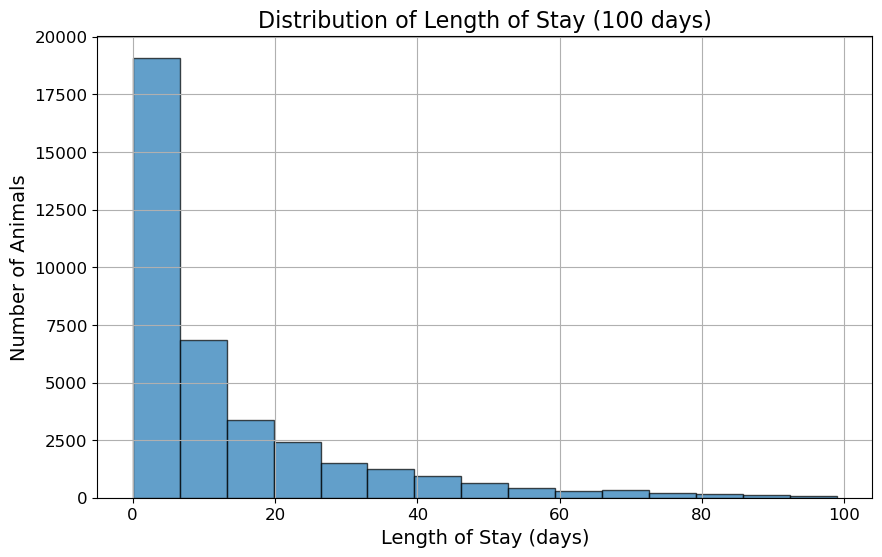

In [3]:
# Plot the length of stay
plt.figure(figsize=(10, 6))
plt.hist(df[df.Days_in_Shelter<100]['Days_in_Shelter'], bins=15, edgecolor='k', alpha=0.7)
plt.title('Distribution of Length of Stay (100 days)', fontsize=16)
plt.xlabel('Length of Stay (days)', fontsize=14)
plt.ylabel('Number of Animals', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

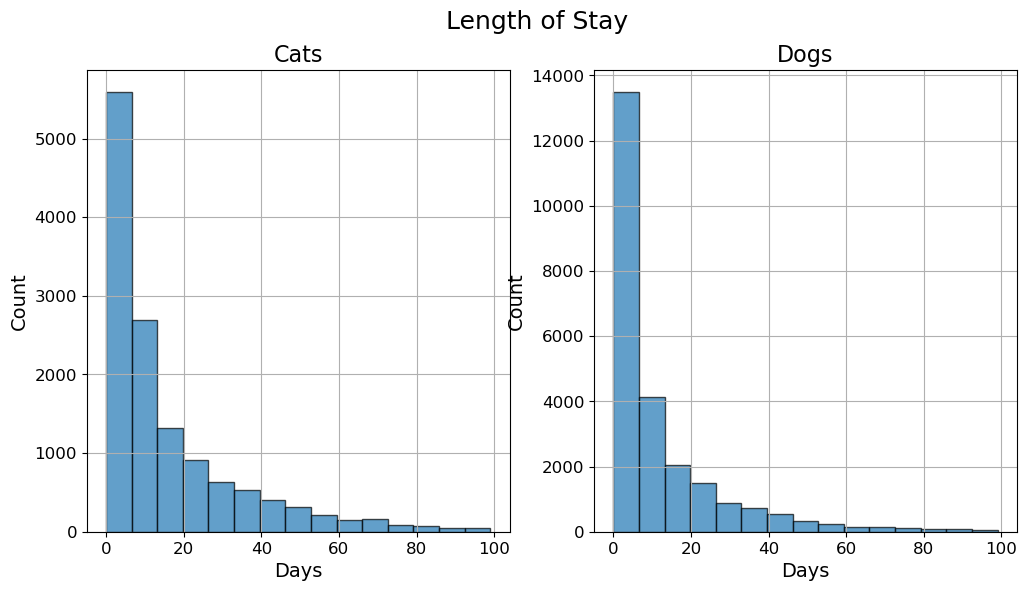

In [4]:
# Log transformation of the length of stay
df['Log Length of Stay'] = np.log1p(df['Days_in_Shelter'])  # log1p is used to handle log(0)

# Separate df for cats and dogs
cats = df[df['Type'] == 'CAT']
dogs = df[df['Type'] == 'DOG']

# Plot the log-transformed length of stay for cats
plt.figure(figsize=(12, 6))
plt.suptitle('Length of Stay', fontsize=18)

plt.subplot(1, 2, 1)
plt.hist(cats[cats.Days_in_Shelter<100]['Days_in_Shelter'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Cats', fontsize=16)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

# Plot the log-transformed length of stay for dogs
plt.subplot(1, 2, 2)
plt.hist(dogs[dogs.Days_in_Shelter<100]['Days_in_Shelter'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Dogs', fontsize=16)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

In [5]:
df['Intake_Type'].unique()

array(['STRAY', 'CONFISCATE', 'OWNER SURRENDER', 'TRANSFER', 'QUARANTINE',
       'Unknown', 'ADOPTION RETURN', 'BORN HERE'], dtype=object)

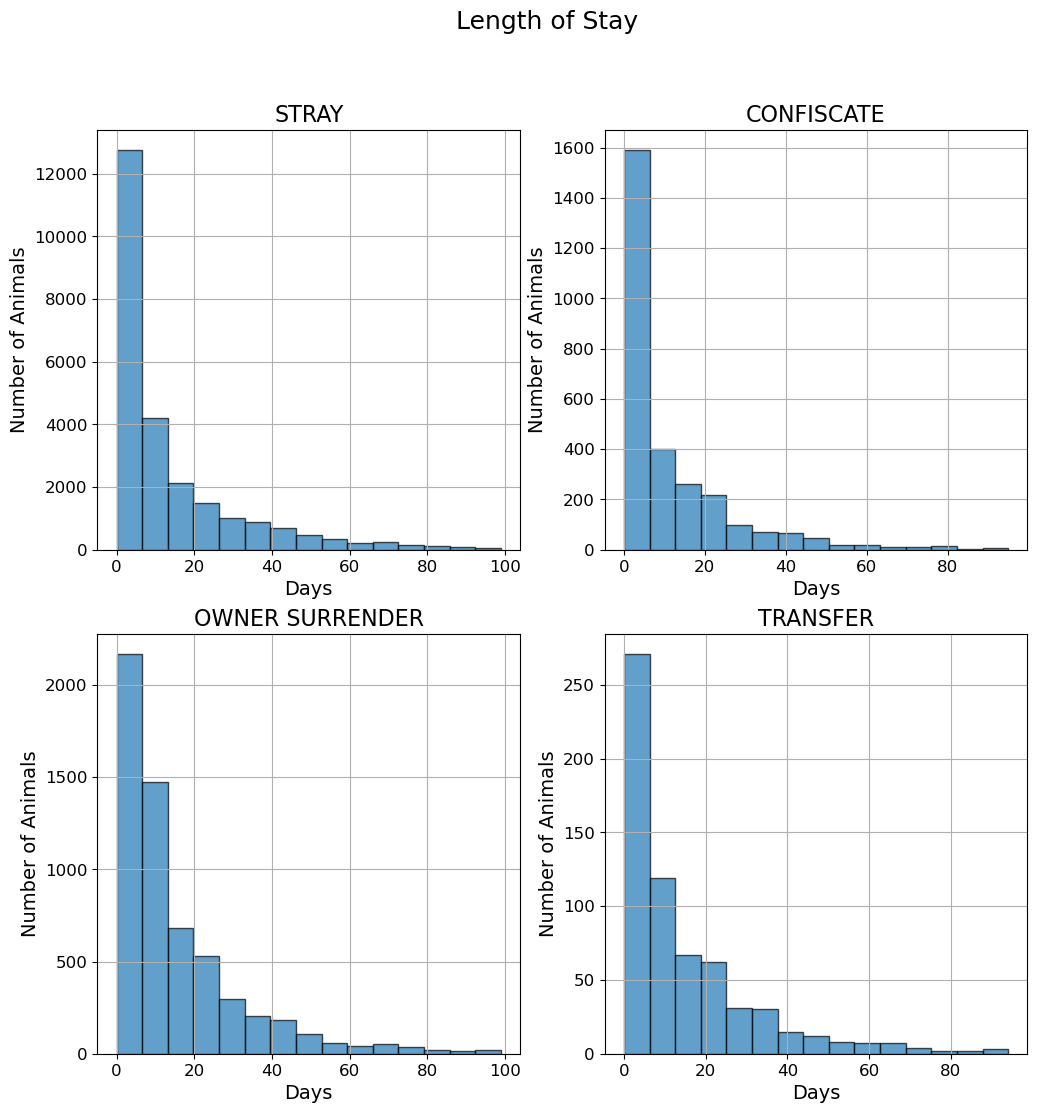

In [6]:
# Log transformation of the length of stay
df['Log Length of Stay'] = np.log1p(df['Days_in_Shelter'])  # log1p is used to handle log(0)

# Plot the log-transformed length of stay for cats
plt.figure(figsize=(12, 12))
plt.suptitle('Length of Stay', fontsize=18)
col = 'Intake_Type'
cat_list = df[col].unique()
rows = 2
cols = 2

for ind in range(len(cat_list))[:rows*cols]:
    temp_df = df[df[col]==cat_list[ind]]
    plt.subplot(rows, cols, ind+1)
    plt.hist(temp_df[temp_df.Days_in_Shelter<100]['Days_in_Shelter'].dropna(), bins=15, edgecolor='k', alpha=0.7)
    plt.title(cat_list[ind], fontsize=16)
    plt.xlabel('Days', fontsize=14)
    plt.ylabel('Number of Animals', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)




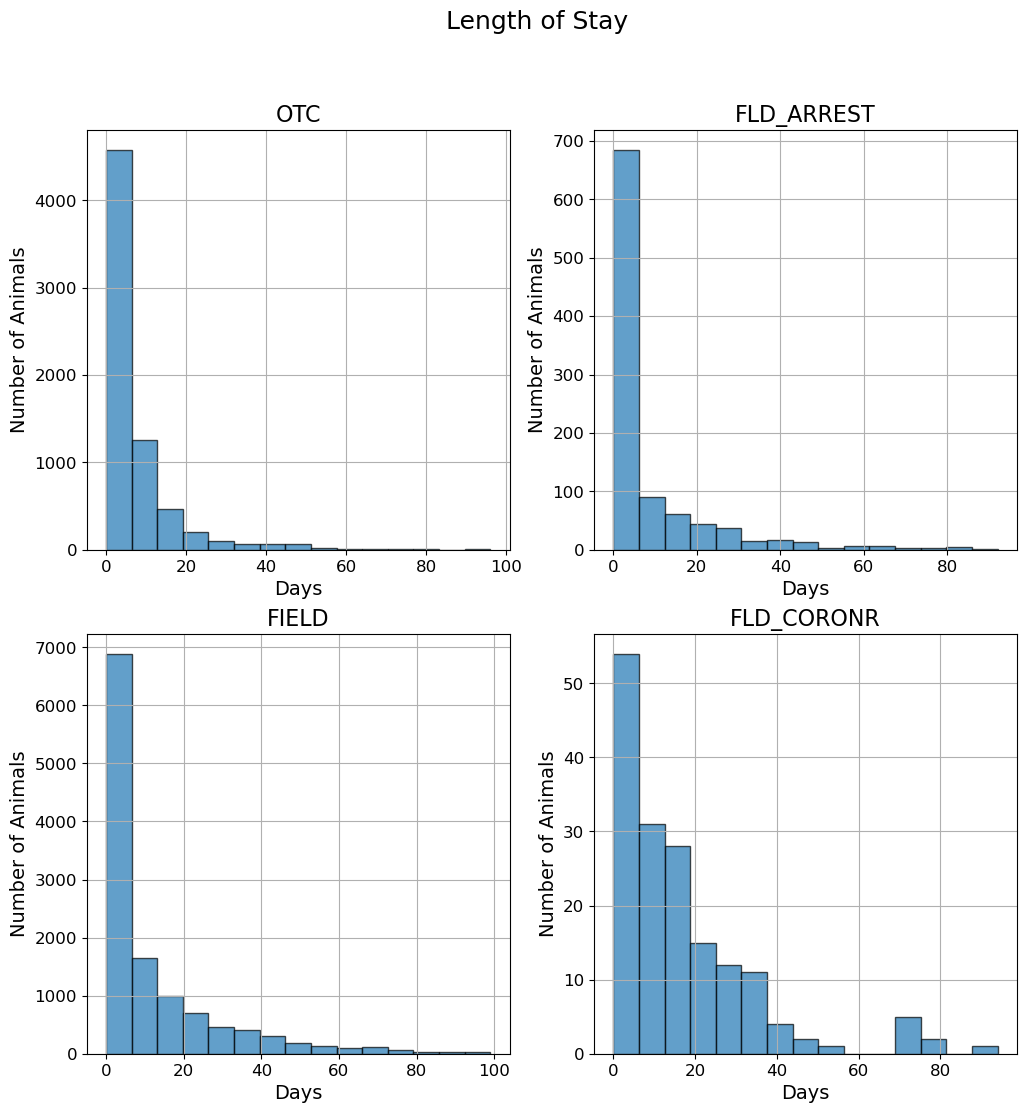

In [7]:
# Log transformation of the length of stay
df['Log Length of Stay'] = np.log1p(df['Days_in_Shelter'])  # log1p is used to handle log(0)

# Plot the log-transformed length of stay for cats
plt.figure(figsize=(12, 12))
plt.suptitle('Length of Stay', fontsize=18)
col = 'Intake_Subtype'
cat_list = df[col].unique()
rows = 2
cols = 2

for ind in range(len(cat_list))[:rows*cols]:
    temp_df = df[df[col]==cat_list[ind]]
    plt.subplot(rows, cols, ind+1)
    plt.hist(temp_df[temp_df.Days_in_Shelter<100]['Days_in_Shelter'].dropna(), bins=15, edgecolor='k', alpha=0.7)
    plt.title(cat_list[ind], fontsize=16)
    plt.xlabel('Days', fontsize=14)
    plt.ylabel('Number of Animals', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)




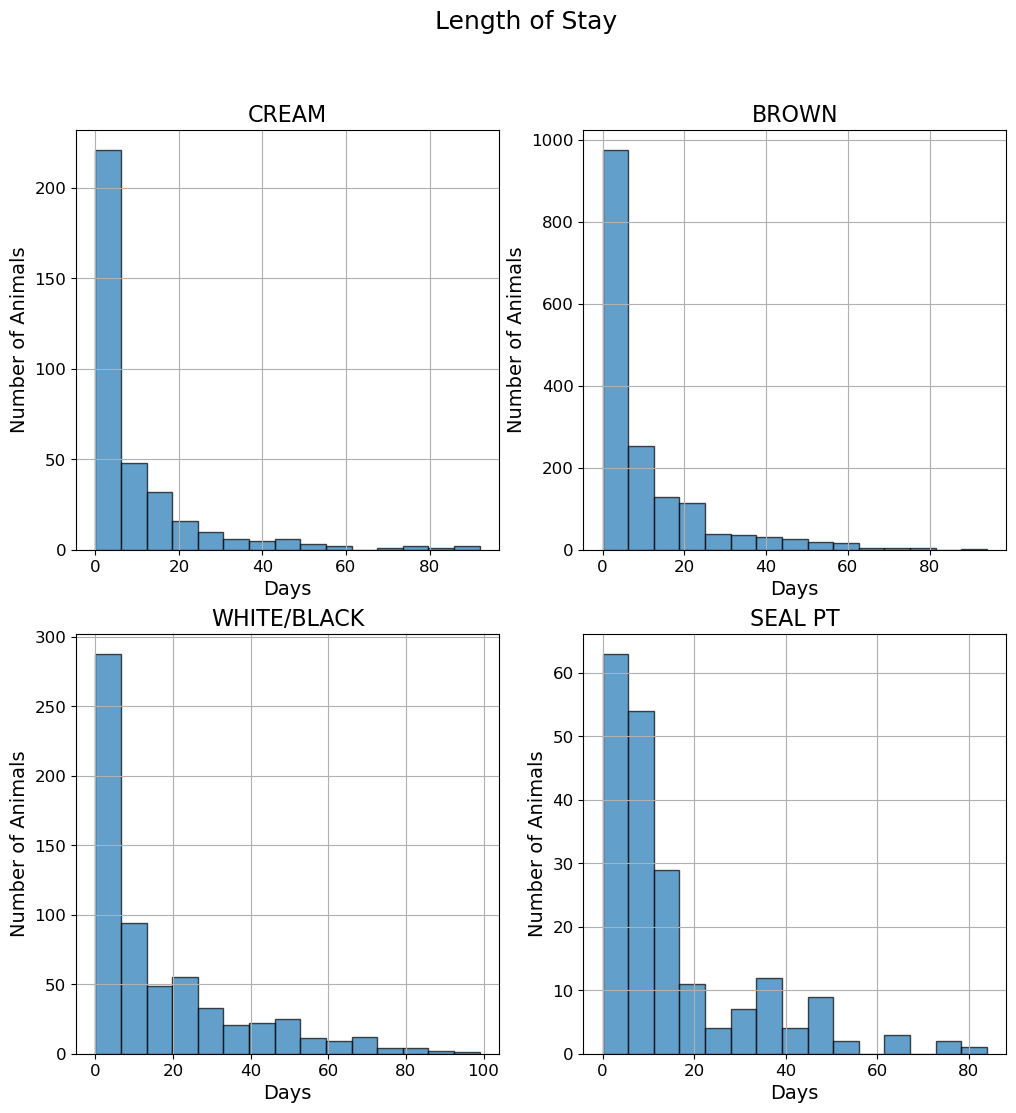

In [8]:
# Log transformation of the length of stay
df['Log Length of Stay'] = np.log1p(df['Days_in_Shelter'])  # log1p is used to handle log(0)

# Plot the log-transformed length of stay for cats
plt.figure(figsize=(12, 12))
plt.suptitle('Length of Stay', fontsize=18)
col = 'Color'
cat_list = df[col].unique()
rows = 2
cols = 2

for ind in range(len(cat_list))[:rows*cols]:
    temp_df = df[df[col]==cat_list[ind]]
    plt.subplot(rows, cols, ind+1)
    plt.hist(temp_df[temp_df.Days_in_Shelter<100]['Days_in_Shelter'].dropna(), bins=15, edgecolor='k', alpha=0.7)
    plt.title(cat_list[ind], fontsize=16)
    plt.xlabel('Days', fontsize=14)
    plt.ylabel('Number of Animals', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)




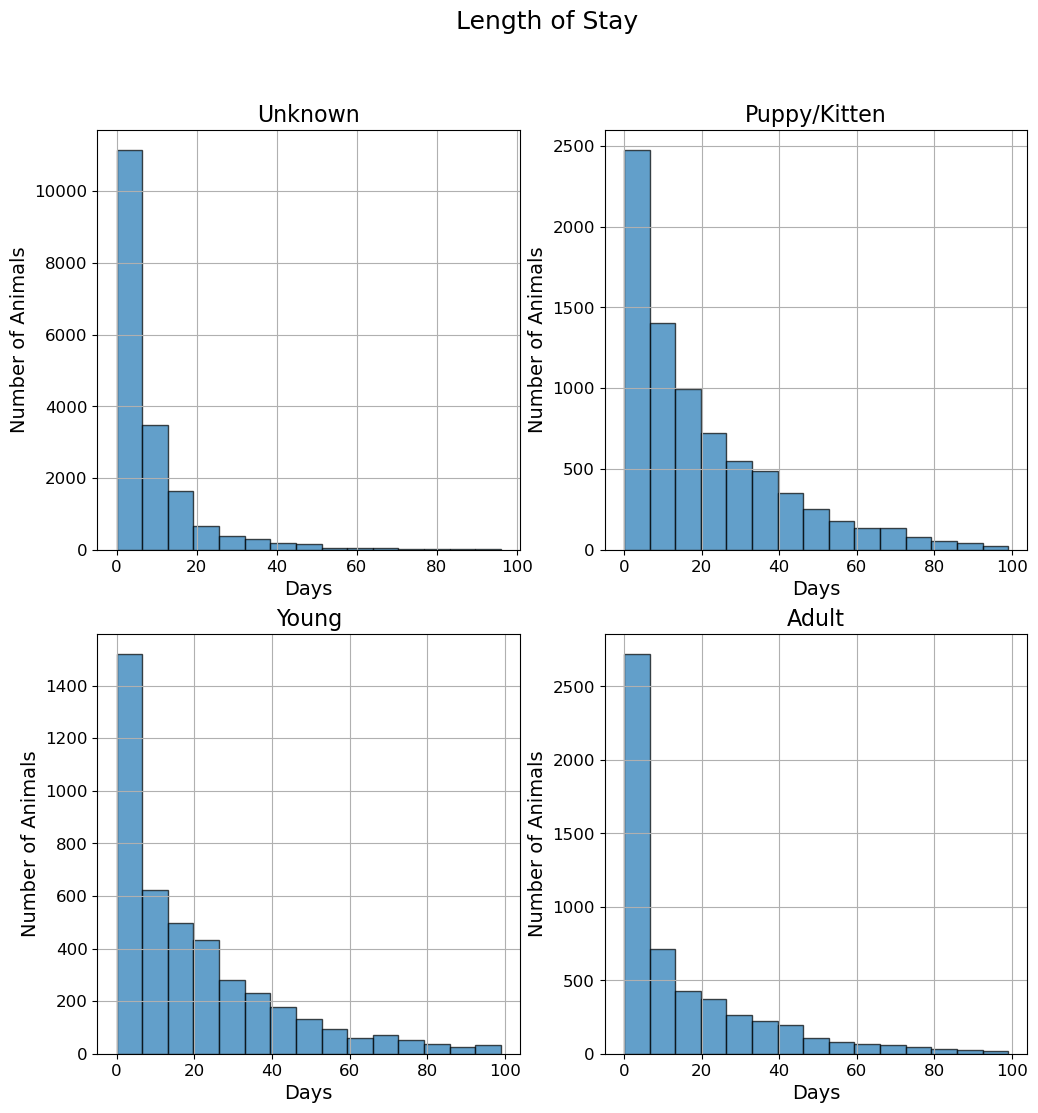

In [9]:
# Log transformation of the length of stay
df['Log Length of Stay'] = np.log1p(df['Days_in_Shelter'])  # log1p is used to handle log(0)

# Plot the log-transformed length of stay for cats
plt.figure(figsize=(12, 12))
plt.suptitle('Length of Stay', fontsize=18)
col = 'Age_Group'
cat_list = df[col].unique()
rows = 2
cols = 2
x_axis = 'Days_in_Shelter' # 'Days_in_Shelter' or 'Log Length of Stay'

for ind in range(len(cat_list))[:rows*cols]:
    temp_df = df[df[col]==cat_list[ind]]
    plt.subplot(rows, cols, ind+1)
    if x_axis == 'Days_in_Shelter':
        plt.hist(temp_df[temp_df.Days_in_Shelter<100][x_axis].dropna(), bins=15, edgecolor='k', alpha=0.7)
    else:
        plt.hist(temp_df[x_axis].dropna(), bins=15, edgecolor='k', alpha=0.7)
    plt.title(cat_list[ind], fontsize=16)
    plt.xlabel(x_axis.split('_')[0].title(), fontsize=14)
    plt.ylabel('Number of Animals', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)




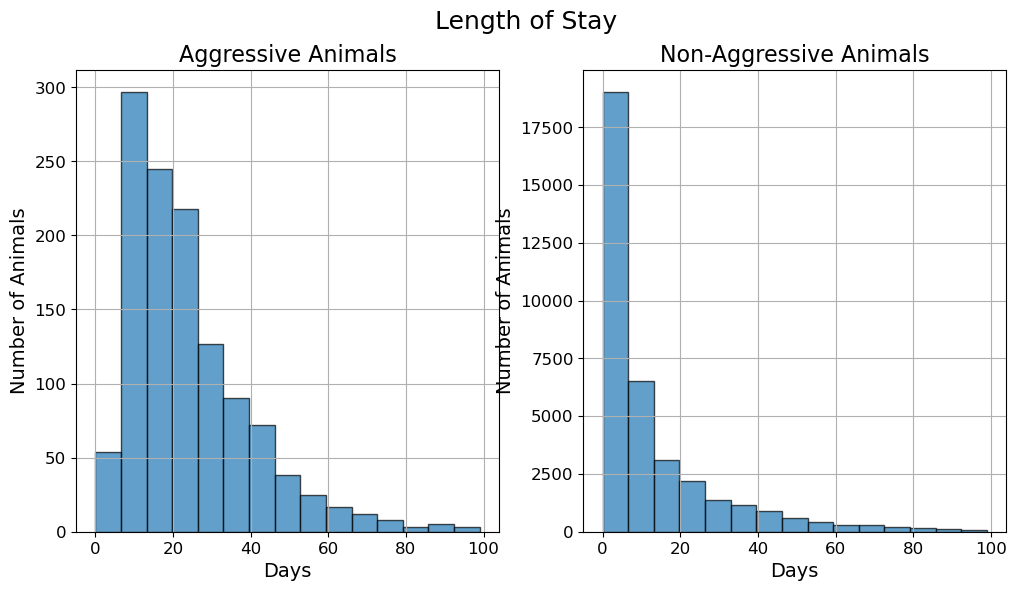

In [10]:
# Log transformation of the length of stay
df['Log Length of Stay'] = np.log1p(df['Days_in_Shelter'])  # log1p is used to handle log(0)

# Separate df for cats and dogs
agressive = df[df['Is_Aggressive'] == 1]
not_aggressive = df[df['Is_Aggressive'] == 0]

# Plot the log-transformed length of stay for cats
plt.figure(figsize=(12, 6))
plt.suptitle('Length of Stay', fontsize=18)
plt.subplot(1, 2, 1)
plt.hist(agressive[agressive.Days_in_Shelter<100]['Days_in_Shelter'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Aggressive Animals', fontsize=16)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Number of Animals', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

# Plot the log-transformed length of stay for dogs
plt.subplot(1, 2, 2)
plt.hist(not_aggressive[not_aggressive.Days_in_Shelter<100]['Days_in_Shelter'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Non-Aggressive Animals', fontsize=16)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Number of Animals', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)


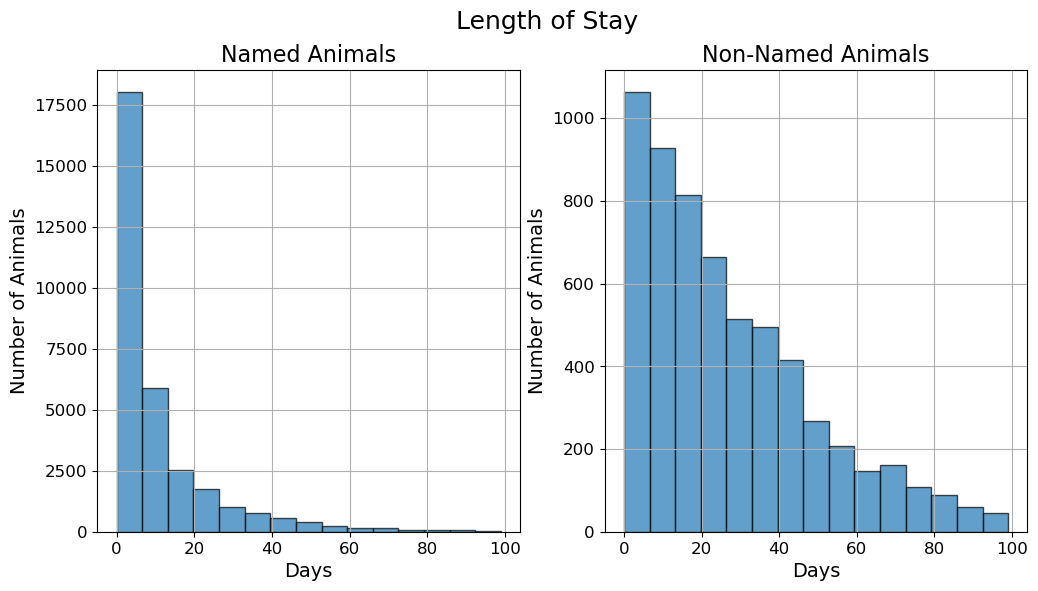

In [11]:
# Log transformation of the length of stay
df['Log Length of Stay'] = np.log1p(df['Days_in_Shelter'])  # log1p is used to handle log(0)

# Separate df for cats and dogs
Named = df[df['Has_Name'] == 1]
not_Named = df[df['Has_Name'] == 0]

# Plot the log-transformed length of stay for cats
plt.figure(figsize=(12, 6))
plt.suptitle('Length of Stay', fontsize=18)
plt.subplot(1, 2, 1)
plt.hist(Named[Named.Days_in_Shelter<100]['Days_in_Shelter'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Named Animals', fontsize=16)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Number of Animals', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

# Plot the log-transformed length of stay for dogs
plt.subplot(1, 2, 2)
plt.hist(not_Named[not_Named.Days_in_Shelter<100]['Days_in_Shelter'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Non-Named Animals', fontsize=16)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Number of Animals', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)


In [12]:
# Create a date range from the minimum intake date to the maximum outcome date
SR_df = df[df.Intake_Jurisdiction=='SANTA ROSA']
date_range = pd.date_range(start=SR_df['Intake_Date'].min(), end=SR_df['Outcome_Date'].max())

# Initialize a time series dfFrame
SR_occupancy_ts = pd.DataFrame(0, index=date_range, columns=['Occupancy'])

# Calculate daily occupancy
for _, row in SR_df.iterrows():
    intake_date = row['Intake_Date']
    outcome_date = row['Outcome_Date']
    SR_occupancy_ts.loc[intake_date:outcome_date, 'Occupancy'] += 1

# Create a date range from the minimum intake date to the maximum outcome date
C_df = df[df.Intake_Jurisdiction=='COUNTY']
date_range = pd.date_range(start=C_df['Intake_Date'].min(), end=C_df['Outcome_Date'].max())

# Initialize a time series dfFrame
C_occupancy_ts = pd.DataFrame(0, index=date_range, columns=['Occupancy'])

# Calculate daily occupancy
for _, row in C_df.iterrows():
    intake_date = row['Intake_Date']
    outcome_date = row['Outcome_Date']
    C_occupancy_ts.loc[intake_date:outcome_date, 'Occupancy'] += 1


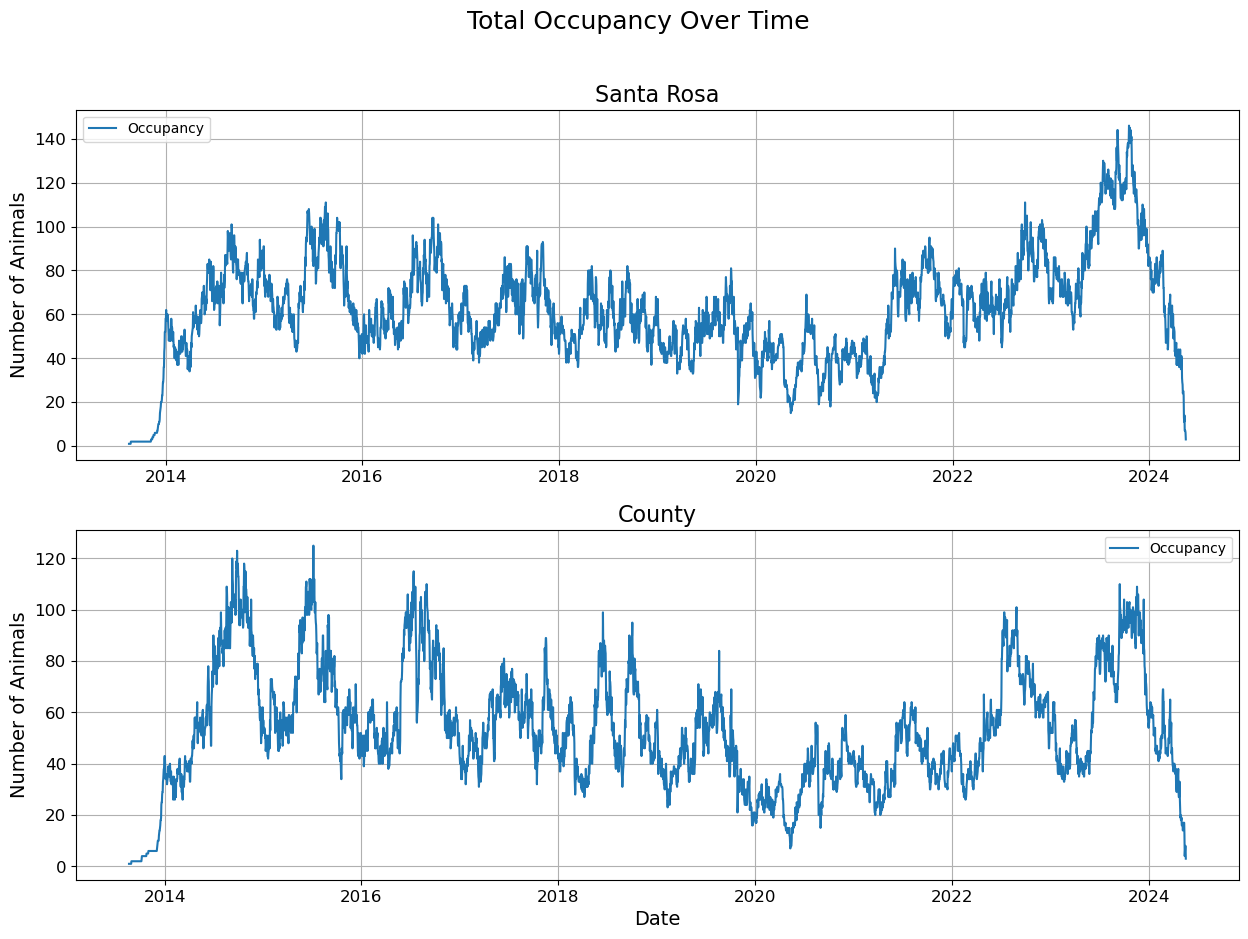

In [13]:
# Plot the time series

plt.figure(figsize=(15, 10))
plt.suptitle('Total Occupancy Over Time', fontsize=18)
plt.subplot(2, 1, 1)
plt.plot(SR_occupancy_ts.index, SR_occupancy_ts['Occupancy'], label='Occupancy')
plt.title('Santa Rosa', fontsize=16)
# plt.xlabel('Date')
plt.ylabel('Number of Animals', fontsize=14)
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
# Plot the time series
plt.subplot(2, 1, 2)
plt.plot(C_occupancy_ts.index, C_occupancy_ts['Occupancy'], label='Occupancy')
plt.title('County', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Animals', fontsize=14)
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

In [14]:
df.Intake_Jurisdiction.value_counts()

Intake_Jurisdiction
Unknown          12947
SANTA ROSA       12376
COUNTY           11022
*WINDSOR          1386
OUT OF COUNTY      158
*ROHNERT PARK       69
*HEALDSBURG         52
*SONOMA             51
*PETALUMA           49
*CLOVERDALE         24
*SEBASTOPOL         22
*TRIBAL RESV        13
*COTATI              7
UNKNOWN              6
Name: count, dtype: int64

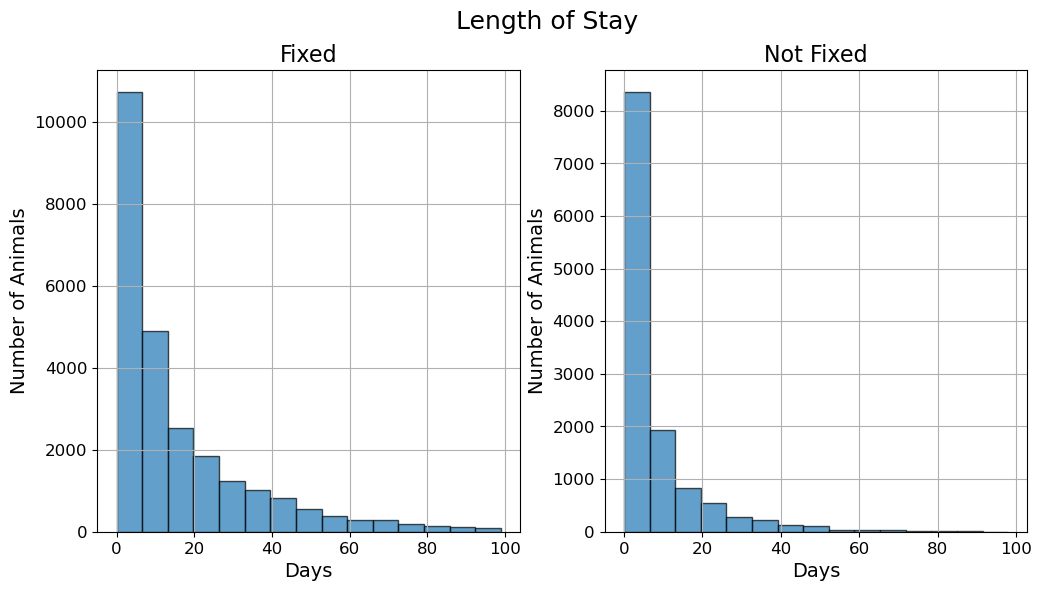

In [15]:
# Log transformation of the length of stay
df['Log Length of Stay'] = np.log1p(df['Days_in_Shelter'])  # log1p is used to handle log(0)

# Separate df for cats and dogs
positive = df[df['Is_Fixed'] == 1]
negative = df[df['Is_Fixed'] == 0]

# Plot the log-transformed length of stay for cats
plt.figure(figsize=(12, 6))
plt.suptitle('Length of Stay', fontsize=18)

plt.subplot(1, 2, 1)
plt.hist(positive[positive.Days_in_Shelter<100]['Days_in_Shelter'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Fixed', fontsize=16)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Number of Animals', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

# Plot the log-transformed length of stay for dogs
plt.subplot(1, 2, 2)
plt.hist(negative[negative.Days_in_Shelter<100]['Days_in_Shelter'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Not Fixed', fontsize=16)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Number of Animals', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

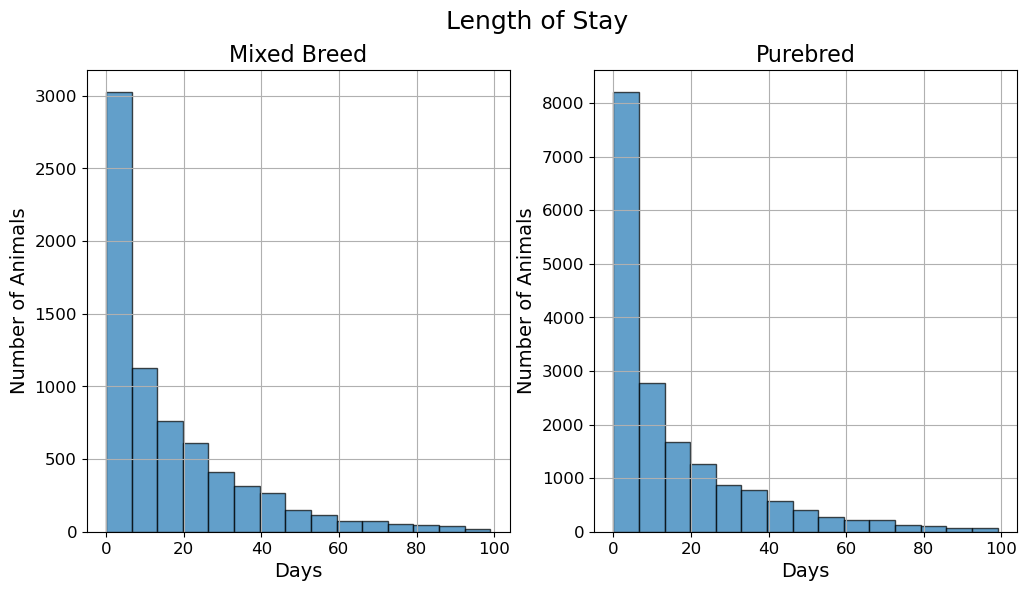

In [16]:
# Log transformation of the length of stay
df['Log Length of Stay'] = np.log1p(df['Days_in_Shelter'])  # log1p is used to handle log(0)

# Separate df for cats and dogs
positive = df[df['Is_Mixed_Breed'] == 1]
negative = df[df['Is_Mixed_Breed'] == 0]

# Plot the log-transformed length of stay for cats
plt.figure(figsize=(12, 6))
plt.suptitle('Length of Stay', fontsize=18)

plt.subplot(1, 2, 1)
plt.hist(positive[positive.Days_in_Shelter<100]['Days_in_Shelter'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Mixed Breed', fontsize=16)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Number of Animals', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

# Plot the log-transformed length of stay for dogs
plt.subplot(1, 2, 2)
plt.hist(negative[negative.Days_in_Shelter<100]['Days_in_Shelter'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Purebred', fontsize=16)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Number of Animals', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

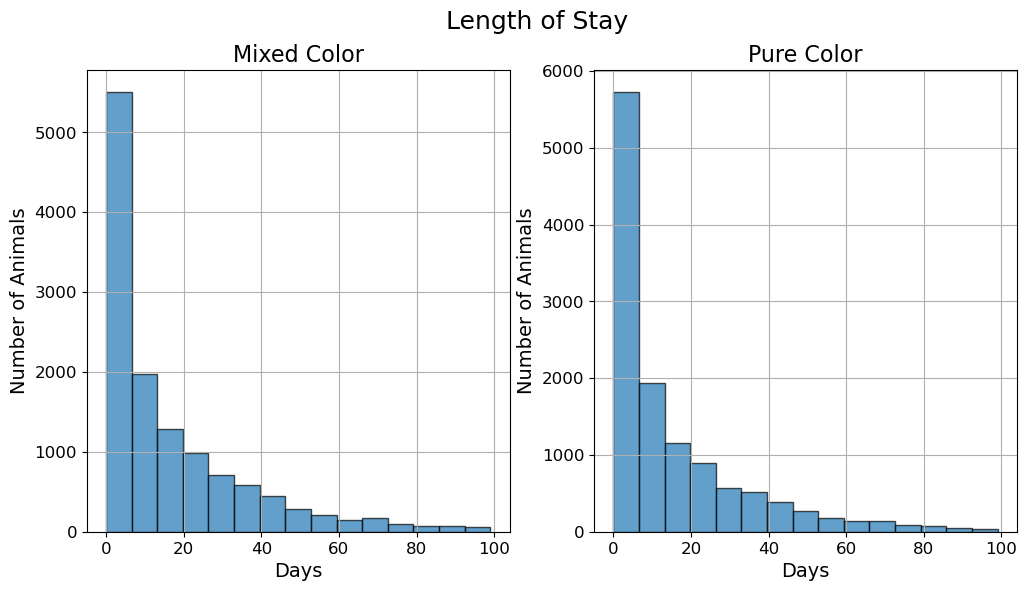

In [17]:
# Log transformation of the length of stay
df['Log Length of Stay'] = np.log1p(df['Days_in_Shelter'])  # log1p is used to handle log(0)

# Separate df for cats and dogs
positive = df[df['Is_Multicolor'] == 1]
negative = df[df['Is_Multicolor'] == 0]

# Plot the log-transformed length of stay for cats
plt.figure(figsize=(12, 6))
plt.suptitle('Length of Stay', fontsize=18)

plt.subplot(1, 2, 1)
plt.hist(positive[positive.Days_in_Shelter<100]['Days_in_Shelter'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Mixed Color', fontsize=16)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Number of Animals', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

# Plot the log-transformed length of stay for dogs
plt.subplot(1, 2, 2)
plt.hist(negative[negative.Days_in_Shelter<100]['Days_in_Shelter'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Pure Color', fontsize=16)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Number of Animals', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

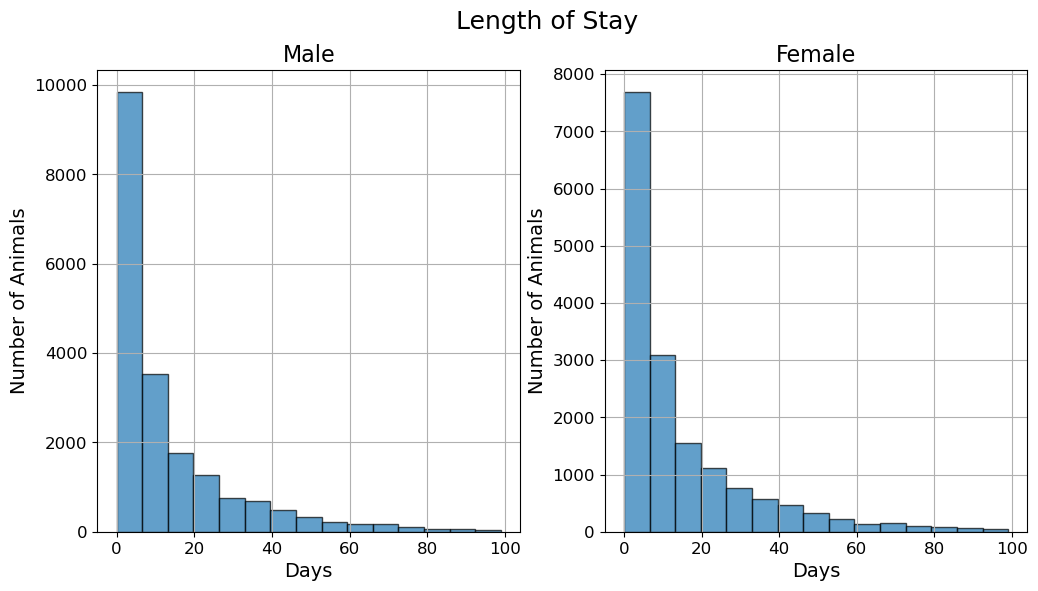

In [18]:
# Log transformation of the length of stay
df['Log Length of Stay'] = np.log1p(df['Days_in_Shelter'])  # log1p is used to handle log(0)

# Separate df for cats and dogs
Male = df[df['Sex'] == 'MALE']
Female = df[df['Sex'] == 'FEMALE']

# Plot the log-transformed length of stay for cats
plt.figure(figsize=(12, 6))
plt.suptitle('Length of Stay', fontsize=18)

plt.subplot(1, 2, 1)
plt.hist(Male[Male.Days_in_Shelter<100]['Days_in_Shelter'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Male', fontsize=16)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Number of Animals', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

# Plot the log-transformed length of stay for dogs
plt.subplot(1, 2, 2)
plt.hist(Female[Female.Days_in_Shelter<100]['Days_in_Shelter'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Female', fontsize=16)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Number of Animals', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

/Users/robchimel/opt/anaconda3/envs/cv_281_3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/robchimel/opt/anaconda3/envs/cv_281_3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/robchimel/opt/anaconda3/envs/cv_281_3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/robchimel/opt/anaconda3/envs/cv_281_3/lib/python3.8/site-packages/sklearn/clus

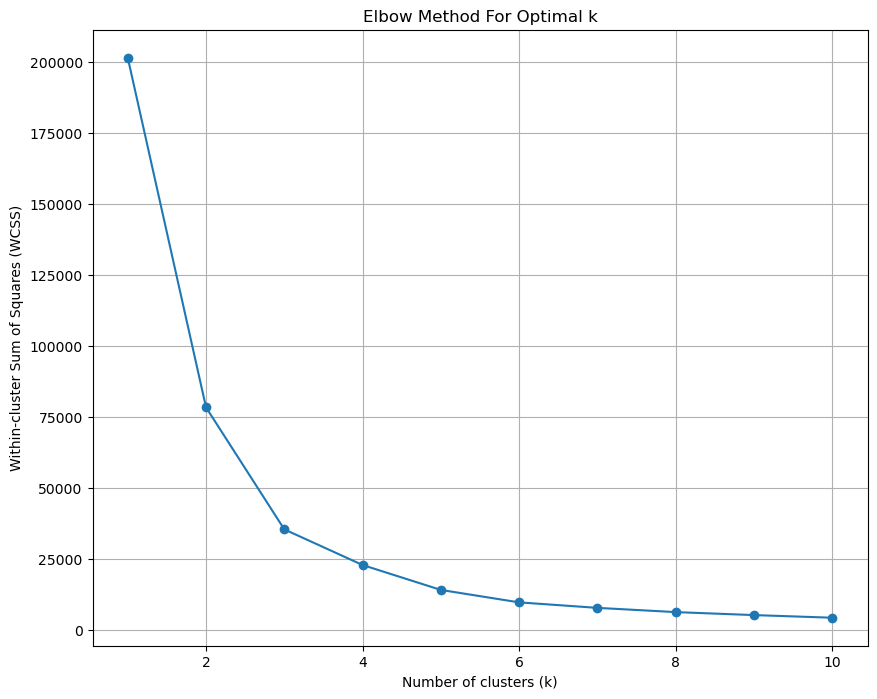

In [19]:
embeddings = np.array(df.Color_Embedding.tolist())

# Perform PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Function to compute WCSS for different values of k
def compute_wcss(data):
    wcss = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    return wcss

# Compute WCSS
wcss = compute_wcss(reduced_embeddings)

# Plot the elbow curve
plt.figure(figsize=(10, 8))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()

/Users/robchimel/opt/anaconda3/envs/cv_281_3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


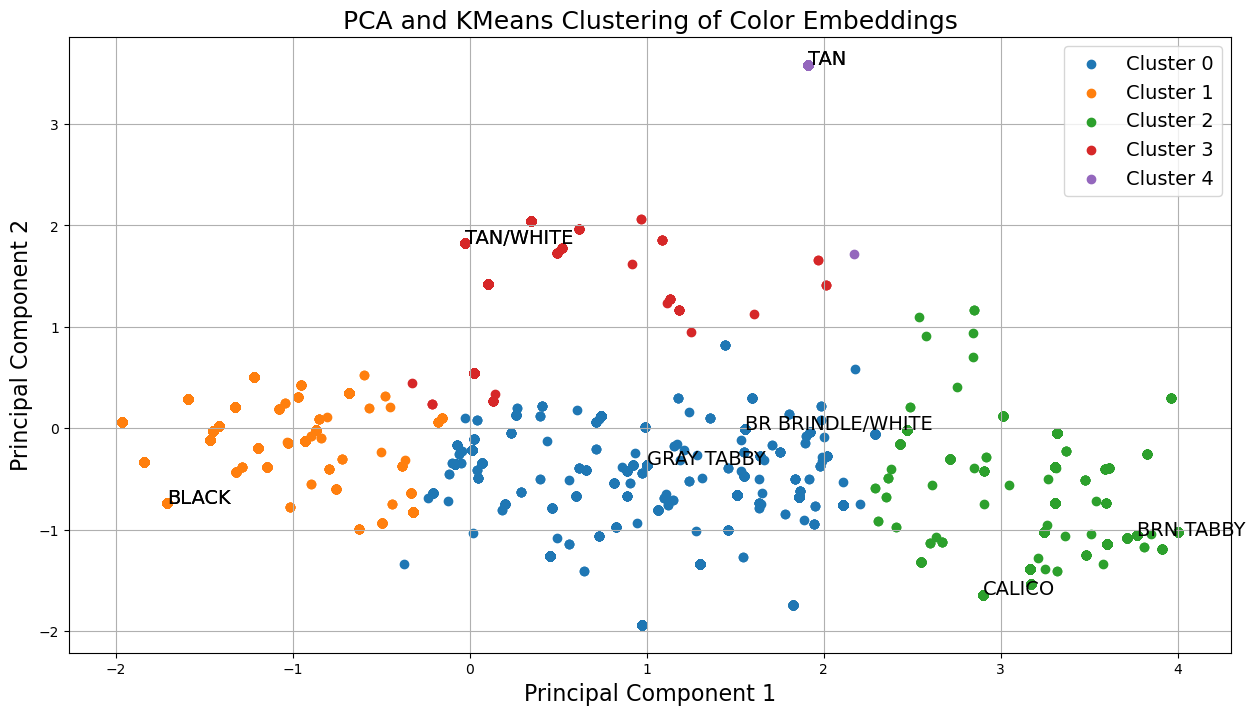

In [20]:
embeddings = np.array(df.Color_Embedding.tolist())

# Perform PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Apply KMeans clustering
n_clusters = 5  # Define the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(reduced_embeddings)

# Create a DataFrame for the reduced embeddings
df_embeddings = pd.DataFrame(reduced_embeddings, columns=['PC1', 'PC2'])
df_embeddings['Color'] = df.Color
df_embeddings['Cluster'] = clusters

# Plot the reduced embeddings
plt.figure(figsize=(15, 8))
# plt.scatter(df_embeddings['PC1'], df_embeddings['PC2'])
# Use a different color for each cluster
for cluster in range(n_clusters):
    clustered_points = df_embeddings[df_embeddings['Cluster'] == cluster]
    plt.scatter(clustered_points['PC1'], clustered_points['PC2'], label=f'Cluster {cluster}')
    for i, color in clustered_points.sample(2).iterrows():
        plt.annotate(color['Color'], (color['PC1'], color['PC2']), fontsize=14)

plt.title('PCA and KMeans Clustering of Color Embeddings', fontsize=18)
plt.xlabel('Principal Component 1', fontsize=16)
plt.ylabel('Principal Component 2', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True)
plt.show()


/Users/robchimel/opt/anaconda3/envs/cv_281_3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/robchimel/opt/anaconda3/envs/cv_281_3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/robchimel/opt/anaconda3/envs/cv_281_3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/robchimel/opt/anaconda3/envs/cv_281_3/lib/python3.8/site-packages/sklearn/clus

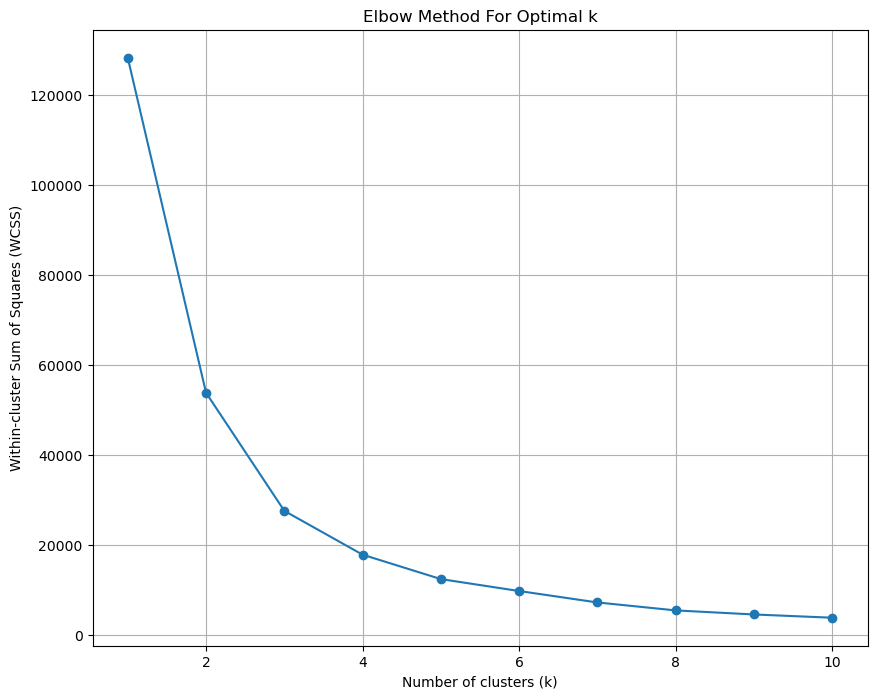

In [21]:
embeddings = np.array(df.Breed_Embedding.tolist())

# Perform PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Function to compute WCSS for different values of k
def compute_wcss(data):
    wcss = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    return wcss

# Compute WCSS
wcss = compute_wcss(reduced_embeddings)

# Plot the elbow curve
plt.figure(figsize=(10, 8))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()

/Users/robchimel/opt/anaconda3/envs/cv_281_3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


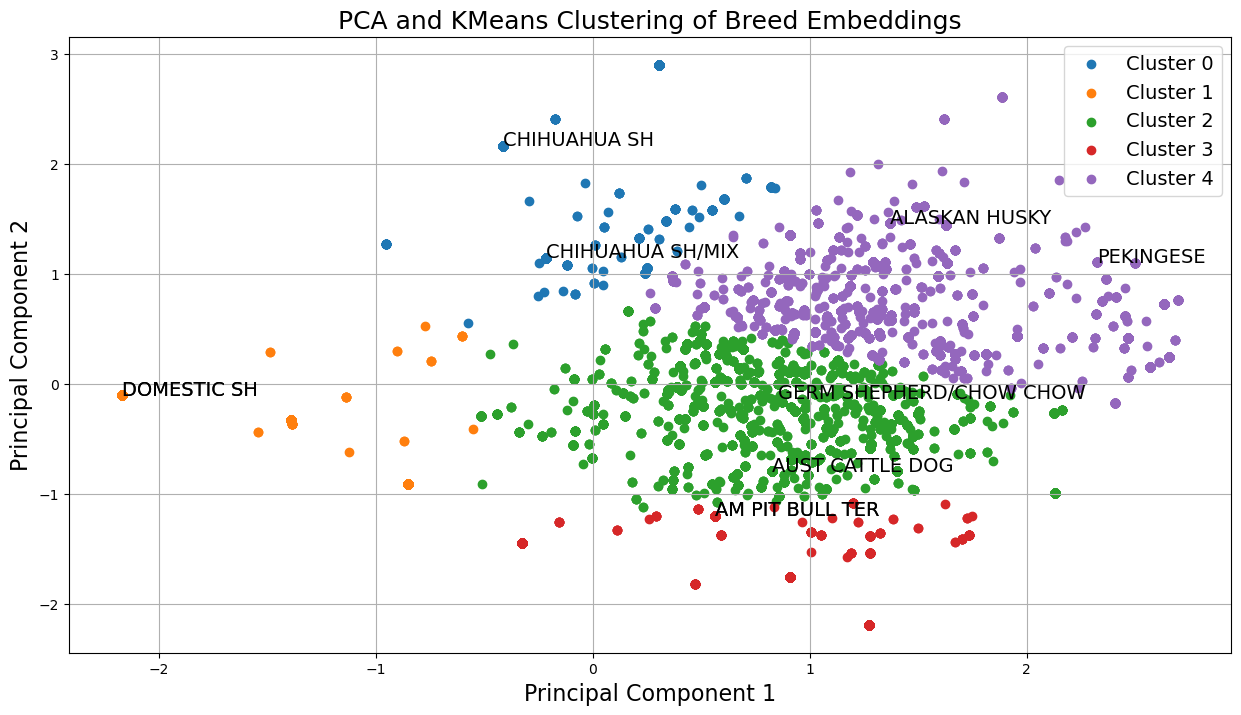

In [22]:
embeddings = np.array(df.Breed_Embedding.tolist())

# Perform PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Apply KMeans clustering
n_clusters = 5  # Define the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(reduced_embeddings)

# Create a DataFrame for the reduced embeddings
df_embeddings = pd.DataFrame(reduced_embeddings, columns=['PC1', 'PC2'])
df_embeddings['Breed'] = df.Breed
df_embeddings['Cluster'] = clusters

# Plot the reduced embeddings
plt.figure(figsize=(15, 8))
# Use a different color for each cluster
for cluster in range(n_clusters):
    clustered_points = df_embeddings[df_embeddings['Cluster'] == cluster]
    plt.scatter(clustered_points['PC1'], clustered_points['PC2'], label=f'Cluster {cluster}')
    for i, color in clustered_points.sample(2).iterrows():
        plt.annotate(color['Breed'], (color['PC1'], color['PC2']), fontsize=14)

plt.title('PCA and KMeans Clustering of Breed Embeddings', fontsize=18)
plt.xlabel('Principal Component 1', fontsize=16)
plt.ylabel('Principal Component 2', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True)
plt.show()


/Users/robchimel/opt/anaconda3/envs/cv_281_3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


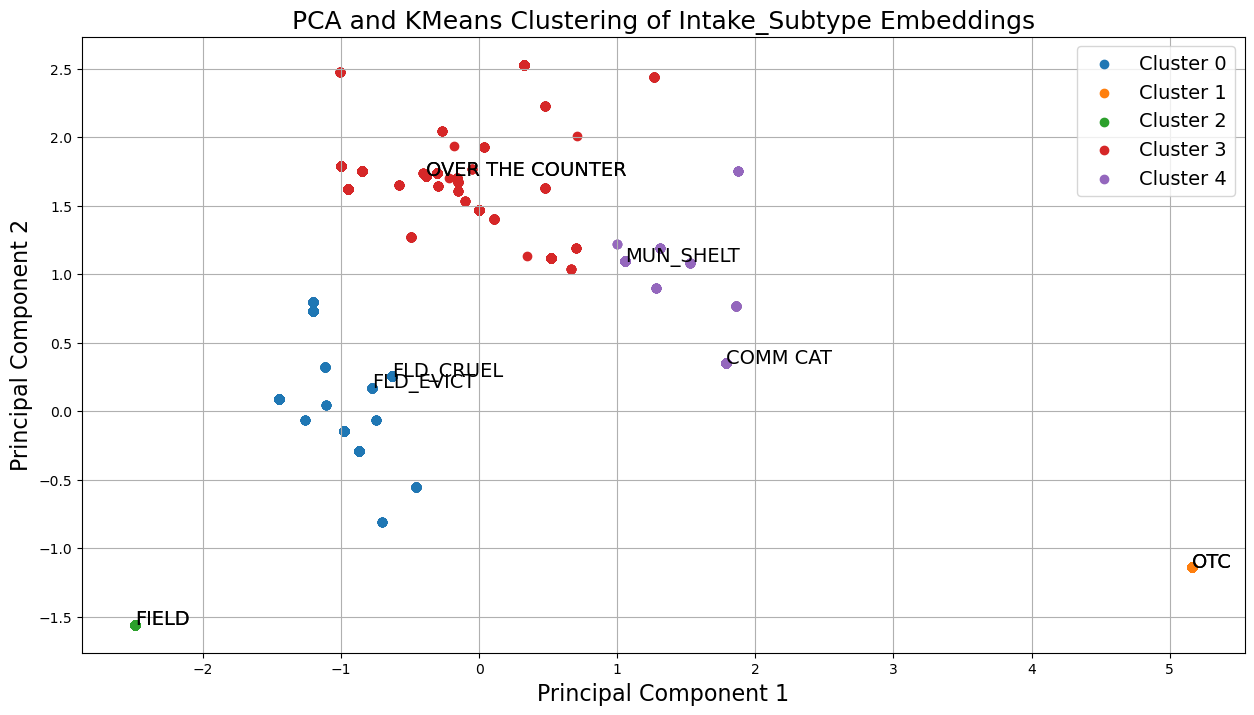

In [23]:
embeddings = np.array(df.Intake_Subtype_Embedding.tolist())

# Perform PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Apply KMeans clustering
n_clusters = 5  # Define the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(reduced_embeddings)

# Create a DataFrame for the reduced embeddings
df_embeddings = pd.DataFrame(reduced_embeddings, columns=['PC1', 'PC2'])
df_embeddings['label'] = df.Days_in_Shelter_Label
df_embeddings['Intake_Subtype'] = df.Intake_Subtype
df_embeddings['Cluster'] = clusters

# Plot the reduced embeddings
plt.figure(figsize=(15, 8))
# Use a different color for each cluster
for cluster in range(n_clusters):
    clustered_points = df_embeddings[df_embeddings['Cluster'] == cluster]
    plt.scatter(clustered_points['PC1'], clustered_points['PC2'], label=f'Cluster {cluster}')
    for i, color in clustered_points.sample(2).iterrows():
        plt.annotate(color['Intake_Subtype'], (color['PC1'], color['PC2']), fontsize=14)

plt.title('PCA and KMeans Clustering of Intake_Subtype Embeddings', fontsize=18)
plt.xlabel('Principal Component 1', fontsize=16)
plt.ylabel('Principal Component 2', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True)
plt.show()


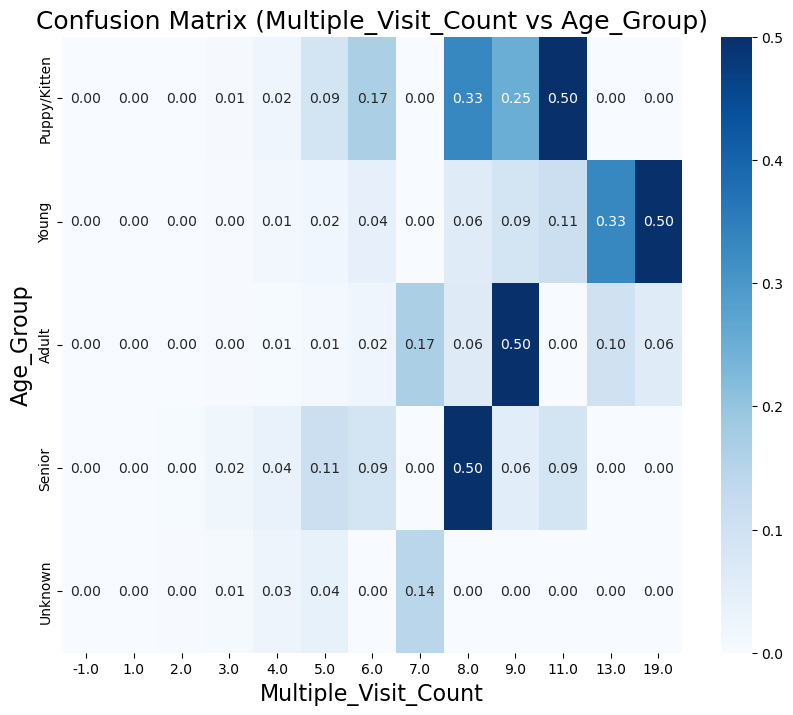

In [24]:
def create_custom_confusion_matrix(df, x_col, y_col, value_col):
    # Normalize the length of stay within each x_col and y_col category
    df['Normalized Length of Stay'] = df.groupby([x_col, y_col])[value_col].transform(lambda x: x / x.sum())

    # Count the occurrences of each category pair
    counts = df.groupby([y_col, x_col]).size().reset_index(name='Count')

    # Sum the normalized length of stay for each category pair
    sum_normalized_los = df.groupby([y_col, x_col])['Normalized Length of Stay'].sum().reset_index(name='Sum Normalized LOS')

    # Merge the counts and sum of normalized length of stay
    merged = pd.merge(counts, sum_normalized_los, on=[y_col, x_col])

    # Calculate the weighted average normalized length of stay
    merged['Weighted Average Normalized LOS'] = merged['Sum Normalized LOS'] / merged['Count']

    # Create a pivot table with the weighted average normalized length of stay
    confusion_matrix = merged.pivot_table(values='Weighted Average Normalized LOS', index=y_col, columns=x_col, aggfunc=np.sum, fill_value=0)

    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix, annot=True, fmt=".2f", cmap="Blues")
    plt.title(f'Confusion Matrix ({x_col} vs {y_col})', fontsize=18)
    plt.xlabel(x_col, fontsize=16)
    plt.ylabel(y_col, fontsize=16)
    plt.show()

    return confusion_matrix

# Create and plot the confusion matrix
conf_matrix = create_custom_confusion_matrix(df, x_col='Multiple_Visit_Count', y_col='Age_Group', value_col='Days_in_Shelter')
